In [1]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patheffects as path_effects

from mplsoccer import Pitch, VerticalPitch, FontManager

from PIL import Image, ImageColor
from io import BytesIO

In [2]:
font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/SourceSerifPro-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/RobotoSlab%5Bwght%5D.ttf')
robotto_thin = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf')

CREDIT = 'Olof Ekborg-Tanner (@olofekborg)'
SOURCE = 'Data: Fotmob'

text_color = '#222222'

In [3]:
match_id = 4382408

url = f'https://www.fotmob.com/api/matchDetails?matchId={match_id}'
response = requests.get(url).json()

df_shots = pd.DataFrame(response['content']['shotmap']['shots'])

In [3]:
url = f'https://www.fotmob.com/api/leagues?id=67'
response = requests.get(url).json()
df_matches = pd.json_normalize(response['matches']['allMatches'])

In [4]:
df_finished_matches = df_matches.loc[df_matches['status.finished']]
all_shots = list()

for match_id in tqdm(df_finished_matches.id.unique()):
    
    url = f'https://www.fotmob.com/api/matchDetails?matchId={match_id}'
    response = requests.get(url).json()
    
    all_shots += response['content']['shotmap']['shots']

df_shots = pd.DataFrame(all_shots)

100%|██████████| 56/56 [00:45<00:00,  1.23it/s]


In [74]:
laurs_shots = list()
for match_id in [4382399,4382459]:
    url = f'https://www.fotmob.com/api/matchDetails?matchId={match_id}'
    response = requests.get(url).json()
    
    laurs_shots += response['content']['shotmap']['shots']
    
df_laurs = pd.DataFrame(laurs_shots)

df_laurs['teamName'] = df_laurs.teamId.apply(lambda x: get_team_name(x))

df_laurs['goal'] = ['eventType'] == 'Goal'
df_laurs_tot = df_laurs.groupby(by='teamName').agg(shots=('isOnTarget','count'),shotsOnTarget=('isOnTarget','sum'),goals=('goal','sum'),insideBox=('isFromInsideBox','sum'))

df_laurs_tot['onTargetConversion'] = df_laurs_tot['shotsOnTarget'] / df_laurs_tot['shots']
df_laurs_tot['insideBoxRatio'] = df_laurs_tot['insideBox'] / df_laurs_tot['shots']
df_laurs_tot['goalConversion'] = df_laurs_tot['goals'] / df_laurs_tot['shotsOnTarget']

In [75]:
df_laurs_tot

,shots,shotsOnTarget,goals,insideBox,onTargetConversion,insideBoxRatio,goalConversion
teamName,,,,,,,
Brommapojkarna,18,10,0,14,0.555556,0.777778,0.0
Häcken,8,4,0,5,0.500000,0.625000,0.0
IFK Göteborg,35,22,0,23,0.628571,0.657143,0.0


In [ ]:
df_shots.columns

Index(['id', 'eventType', 'teamId', 'playerId', 'playerName', 'x', 'y', 'min',
       'minAdded', 'isBlocked', 'isOnTarget', 'blockedX', 'blockedY',
       'goalCrossedY', 'goalCrossedZ', 'expectedGoals',
       'expectedGoalsOnTarget', 'shotType', 'situation', 'period', 'isOwnGoal',
       'onGoalShot', 'isSavedOffLine', 'isFromInsideBox', 'firstName',
       'lastName', 'fullName', 'teamColor'],
      dtype='object')

In [5]:
def get_team_name(id):
    return df_finished_matches.loc[df_finished_matches['home.id'] == f'{id}']['home.name'].values[0]

In [6]:
df_shots['teamName'] = df_shots.teamId.apply(lambda x: get_team_name(x))

df_shots['goal'] = df_shots['eventType'] == 'Goal'
df_total = df_shots.groupby(by='teamName').agg(shots=('isOnTarget','count'),shotsOnTarget=('isOnTarget','sum'),goals=('goal','sum'),insideBox=('isFromInsideBox','sum'))

df_total['onTargetConversion'] = df_total['shotsOnTarget'] / df_total['shots']
df_total['insideBoxRatio'] = df_total['insideBox'] / df_total['shots']
df_total['goalConversion'] = df_total['goals'] / df_total['shotsOnTarget']

In [7]:
df_rank = df_total.sort_values(by='goalConversion', ascending=False).reset_index()
df_rank.index += 1
df_rank.head(16)

,teamName,shots,shotsOnTarget,goals,insideBox,onTargetConversion,insideBoxRatio,goalConversion
1,Halmstads BK,53,29,10,37,0.547170,0.698113,0.344828
2,Kalmar FF,75,42,14,47,0.560000,0.626667,0.333333
3,AIK,91,59,16,51,0.648352,0.560440,0.271186
4,Malmö FF,119,82,19,91,0.689076,0.764706,0.231707
5,IFK Norrköping,77,49,11,50,0.636364,0.649351,0.224490
6,Häcken,98,64,14,64,0.653061,0.653061,0.218750
7,Djurgården,96,57,12,56,0.593750,0.583333,0.210526
8,Mjällby,92,54,10,62,0.586957,0.673913,0.185185
9,IFK Värnamo,75,41,7,37,0.546667,0.493333,0.170732
10,Brommapojkarna,119,71,12,77,0.596639,0.647059,0.169014


In [21]:
df_finished_matches

,round,roundName,pageUrl,id,home.name,home.shortName,home.id,away.name,away.shortName,away.id,status.utcTime,status.finished,status.started,status.cancelled,status.scoreStr,status.reason.short,status.reason.shortKey,status.reason.long,status.reason.longKey
0,1,1,/matches/ifk-norrkoping-vs-malmo-ff/2vyb2a#438...,4382395,IFK Norrköping,IFK Norrköping,8449,Malmö FF,Malmö FF,10237,2024-03-30T14:00:00Z,True,True,False,1 - 5,FT,fulltime_short,Full-Time,finished
1,1,1,/matches/gais-vs-brommapojkarna/2c0c06#4382397,4382397,GAIS,GAIS,8297,Brommapojkarna,Brommapojkarna,8501,2024-03-31T12:00:00Z,True,True,False,0 - 4,FT,fulltime_short,Full-Time,finished
2,1,1,/matches/hammarby-vs-kalmar-ff/2pyumy#4382393,4382393,Hammarby,Hammarby,8248,Kalmar FF,Kalmar FF,9892,2024-03-31T12:00:00Z,True,True,False,3 - 1,FT,fulltime_short,Full-Time,finished
3,1,1,/matches/mjallby-vs-hacken/29lh0e#4382398,4382398,Häcken,Häcken,8428,Mjällby,Mjällby,8127,2024-03-31T14:30:00Z,True,True,False,0 - 1,FT,fulltime_short,Full-Time,finished
4,1,1,/matches/djurgarden-vs-ifk-goteborg/37hdbh#438...,4382394,IFK Göteborg,IFK Göteborg,9893,Djurgården,Djurgården,9802,2024-04-01T12:00:00Z,True,True,False,1 - 4,FT,fulltime_short,Full-Time,finished
5,1,1,/matches/sirius-vs-halmstads-bk/1v0w24#4382426,4382426,Sirius,Sirius,6694,Halmstads BK,Halmstads BK,8310,2024-04-01T12:00:00Z,True,True,False,3 - 0,FT,fulltime_short,Full-Time,finished
6,1,1,/matches/vasteras-sk-vs-aik/1qywtx#4382392,4382392,AIK,AIK,8349,Västerås SK,Västerås SK,6194,2024-04-01T14:30:00Z,True,True,False,1 - 0,FT,fulltime_short,Full-Time,finished
7,1,1,/matches/ifk-varnamo-vs-elfsborg/1nzq3g#4382396,4382396,Elfsborg,Elfsborg,8014,IFK Värnamo,IFK Värnamo,6181,2024-04-01T14:30:00Z,True,True,False,2 - 2,FT,fulltime_short,Full-Time,finished
8,2,2,/matches/aik-vs-brommapojkarna/2cj328#4382424,4382424,Brommapojkarna,Brommapojkarna,8501,AIK,AIK,8349,2024-04-06T13:00:00Z,True,True,False,2 - 2,FT,fulltime_short,Full-Time,finished
9,2,2,/matches/mjallby-vs-ifk-norrkoping/29sxgh#4382422,4382422,Mjällby,Mjällby,8127,IFK Norrköping,IFK Norrköping,8449,2024-04-06T15:30:00Z,True,True,False,3 - 0,FT,fulltime_short,Full-Time,finished


In [8]:
def get_marker(row):
    if row.eventType == 'Goal':
        return 'football'
    elif row.isBlocked:
        return 'x'
    else:
        return 'o'
    
def get_color(row):
    if row.eventType == 'Goal':
        return None
    elif row.isBlocked:
        return '#a03329'
    elif row.isOnTarget:
        return '#234B9A'
    else:
        return '#959595'
    
def get_zorder(row):
    if row.eventType == 'Goal':
        return 5
    if row.isBlocked:
        return 3
    elif row.isOnTarget:
        return 4
    else:
        return 2
    
    
def get_alpha(row):
    if row.eventType == 'Goal':
        return 1.0
    if row.isBlocked:
        return 0.8
    elif row.isOnTarget:
        return 0.8
    else:
        return 0.4
    
def set_label(row):
    if row.eventType == 'Goal':
        return 'Mål'
    elif row.isBlocked:
        return 'Blockerat Skott'
    elif row.isOnTarget:
        return 'Skott på Mål'
    else:
        return 'Miss'

In [9]:
def add_legend(handles, labels):
    handle_dict = {}
    for handle, label in zip(handles, labels):
        if label not in handle_dict.keys():
            handle_dict[label] = handle
    return handle_dict

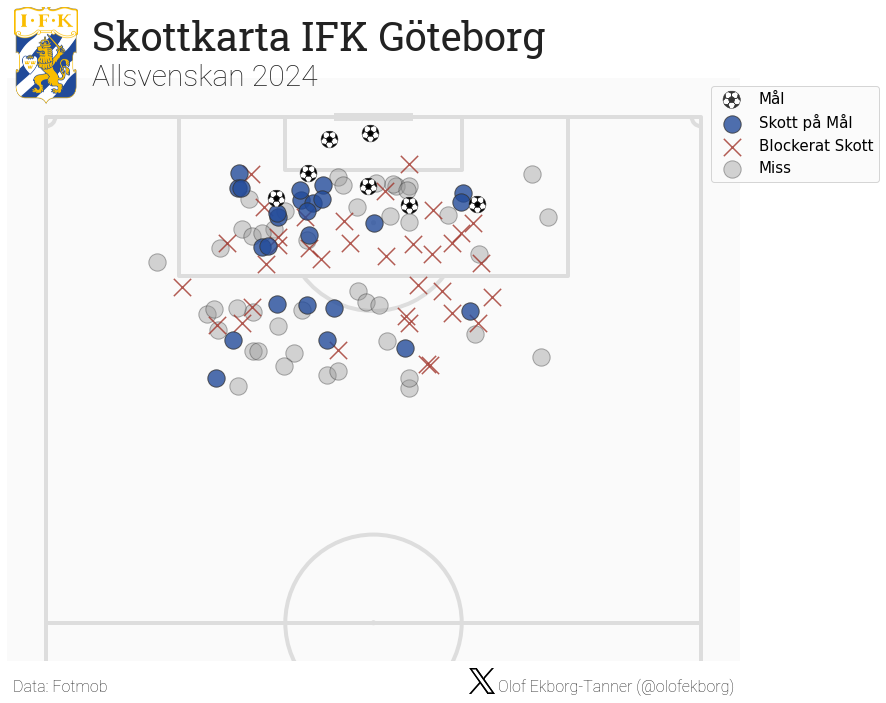

In [10]:
df_ifk_shots = df_shots.loc[df_shots.teamId == 9893]
#df_ifk_shots = df_shots
#df_ifk_shots = df_laurs.loc[df_laurs.teamId == 9893]

#create pitch
pitch = VerticalPitch(pitch_type='custom',pitch_length=105, pitch_width=68, pitch_color='#fafafa',line_color='#dddddd', linewidth=4, corner_arcs=True, half=True)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)


for _, row in df_ifk_shots.iterrows():

    pitch.scatter(row.x, row.y, s=300, 
                  marker=get_marker(row), color=get_color(row), zorder=get_zorder(row), alpha=get_alpha(row), 
                  edgecolor='#343434', ax=ax['pitch'], label=set_label(row)) 
    
# Add legend
handles, labels = ax['pitch'].get_legend_handles_labels()
handle_dict = add_legend(handles, labels)
label_order = ['Mål', 'Skott på Mål', 'Blockerat Skott', 'Miss']
ax['pitch'].legend(handles=[handle_dict[label] for label in label_order], labels=label_order, bbox_to_anchor=(0.95,1.0),facecolor='#fafafa', fontsize=15)

# Add logo
ax_logo = fig.add_axes([0, 0.9, 0.15, 0.15]) # badge
#ax_logo = fig.add_axes([0.46,0.94,0.075,0.075]) # badge    
ax_logo.axis("off")
#url = 'https://upload.wikimedia.org/wikipedia/en/thumb/a/a6/IFK_Goteborg_logo.svg/1200px-IFK_Goteborg_logo.svg.png'
#response = requests.get(url)
img = Image.open('IFK_Goteborg_logo.png')
ax_logo.imshow(img)

# Title
ax['title'].text(0.07, 1, 'Skottkarta IFK Göteborg', fontsize=40, color=text_color,
                                    fontproperties=font_bold.prop, ha='left', va='center',
                                    #path_effects=[path_effects.withStroke(linewidth=0.2, foreground='#005b6d')]
                                   )
ax['title'].text(0.07, 0, 'Allsvenskan 2024', fontsize=30, # | Med Laurs Skjellerup
                                    fontproperties=robotto_thin.prop,
                                    ha='left', va='center', color=text_color,
                                    #path_effects=[path_effects.withStroke(linewidth=0.2, foreground='#005b6d')]
                                  )
# Credits    
ax['endnote'].text(1.05, 0, CREDIT, fontsize=16, color=text_color,
                                           fontproperties=robotto_thin.prop, ha='right', va='center')

ax['endnote'].text(-0.05, 0, SOURCE, fontsize=16, color=text_color,
                                       fontproperties=robotto_thin.prop, ha='left', va='center')

# add twitter logo
ax_twitter = fig.add_axes([0.62, -0.01 ,0.04,0.04])
ax_twitter.axis('off')
url = 'https://about.x.com/content/dam/about-twitter/x/brand-toolkit/logo-black.png.twimg.1920.png'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
ax_twitter.imshow(img)
    
    
plt.savefig(f'figures/skottkarta_alla.png', bbox_inches='tight', dpi=300, transparent=False, facecolor='#fafafa')
plt.show()

## Create bins for each team

In [11]:
team_arrays_enum = enumerate(df_finished_matches['home.id'].unique())

team_array_dict = dict((i,j) for i,j in team_arrays_enum)

### Standard deviations from mean

In [12]:
def get_stds(team_bins):
    stds = np.zeros(shape=(5,12))

    for i in range(5):
        for j in range(12):
            stds[i][j] = (team_bins[4,i,j] - team_bins[:,i,j].mean()) / team_bins[:,i,j].std()
    return stds

def get_diffs(team_bins):
    diffs = np.zeros(shape=(5,12))

    for i in range(5):
        for j in range(12):
            diffs[i][j] = team_bins[4,i,j] - team_bins[:,i,j].mean()
    return diffs

### Rank

In [13]:
def get_ranks(team_bins):
    ranks = np.empty(shape=(5,12), dtype=object)

    for i in range(5):
        for j in range(12):
            if np.nansum(team_bins[:,i,j]) == 0:
                ranks[i][j] = ''
            else:
                ranks[i][j] = f'Rank: {np.where((-team_bins)[:,i,j].argsort() == 4)[0][0] + 1}'
                
    return ranks

In [14]:
def get_team_bins(pitch, df_nom, df_denom=None, team_array_dict=team_array_dict):

    team_bins = np.zeros(shape=(16,5,12))

    for i, team_id in team_array_dict.items():
        
        df_nom_team = df_nom.loc[df_nom.teamId == int(team_id)]
        nom_bins = pitch.bin_statistic(df_nom_team.x, df_nom_team.y, statistic='count', bins=(12, 5), normalize=False)["statistic"]
        
        if df_denom is not None:
            df_denom_team = df_denom.loc[df_denom.teamId == int(team_id)]
            denom_bins = pitch.bin_statistic(df_denom_team.x, df_denom_team.y, statistic='count', bins=(12, 5), normalize=False)["statistic"]
            
            team_bins[i] = nom_bins / denom_bins
        else:
            team_bins[i] = nom_bins
        #team_bins[i] = shots_on_target_bins / shot_bins
        #team_bins[i] = goal_bins / shots_on_target_bins
    
    return team_bins

In [16]:
def get_title(kpi):
    if kpi == 'shots':
        return 'Skott per match'
    if kpi == 'sot%':
        return 'Andel Skott På Mål'
    if kpi == 'goal%':
        return 'Andel Mål från Skott På Mål'

In [ ]:
pitch = VerticalPitch(pitch_type='custom',pitch_length=105, pitch_width=68, pitch_color='#fafafa', line_color='#222222', linewidth=2, corner_arcs=True, half=True,line_zorder=2)
get_team_bins(pitch=pitch, df_nom=df_shots.loc[df_shots.eventType == 'Goal'])[:,2,10:12].sum()

In [48]:
df_shots[df_shots.eventType == 'Goal']

,id,eventType,teamId,playerId,playerName,x,y,min,minAdded,isBlocked,...,isOwnGoal,onGoalShot,isSavedOffLine,isFromInsideBox,firstName,lastName,fullName,teamColor,teamName,goal
4,2664649093,Goal,10237,289140,Isaac Kiese Thelin,93.400000,38.200238,14,NaN,False,...,False,"{'x': 1.8472222222222223, 'y': 0.2582010569312...",False,True,Isaac Kiese,Thelin,Isaac Kiese Thelin,#3991CC,Malmö FF,True
14,2664668939,Goal,10237,741561,Erik Botheim,101.396552,35.982500,32,NaN,False,...,False,"{'x': 0.6570767195767175, 'y': 0.0543581172486...",False,True,Erik,Botheim,Erik Botheim,#3991CC,Malmö FF,True
19,2664685453,Goal,10237,1156569,Sebastian Nanasi,96.026316,44.981656,44,NaN,False,...,False,"{'x': 1.2017195767195774, 'y': 0.1511835135978...",False,True,Sebastian,Nanasi,Sebastian Nanasi,#3991CC,Malmö FF,True
22,2664729165,Goal,10237,31568,Søren Rieks,90.200000,31.560000,57,NaN,False,...,False,"{'x': 0.15277777777777768, 'y': 0.074742411216...",False,True,Søren,Rieks,Søren Rieks,#3991CC,Malmö FF,True
28,2664759071,Goal,10237,493159,Stefano Holmquist Vecchia,97.956140,31.407500,76,NaN,False,...,False,"{'x': 1.3832671957671967, 'y': 0.0543581172486...",False,True,Stefano Holmquist,Vecchia,Stefano Holmquist Vecchia,#3991CC,Malmö FF,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,2683317335,Goal,8248,820490,Shaquille Pinas,97.473684,35.753750,64,NaN,False,...,False,"{'x': 1.2017195767195774, 'y': 0.2904761890476...",False,True,Shaquille,Pinas,Shaquille Pinas,#00AD5E,Hammarby,True
1491,2683319383,Goal,6181,940297,Hampus Näsström,100.637931,34.305000,68,NaN,False,...,False,"{'x': 1.3227513227513243, 'y': 0.2904761890476...",False,True,Hampus,Näsström,Hampus Näsström,#0868A0,IFK Värnamo,True
1510,2683865717,Goal,8297,1239553,Axel Henriksson,96.219298,30.797500,33,NaN,False,...,False,"{'x': 1.282407407407408, 'y': 0.03227513211640...",False,True,Axel,Henriksson,Axel Henriksson,#008840,GAIS,True
1522,2683895523,Goal,8297,965327,Alexander Ahl Holmström,91.500000,49.325605,76,NaN,False,...,False,"{'x': 1.141203703703705, 'y': 0.04246727910052...",False,True,Alexander Ahl,Holmström,Alexander Ahl Holmström,#008840,GAIS,True


In [17]:
def cbar_ticks(x, kpi):
    if kpi == 'shots':
        return x
    else:
        if x > 0:
            return f'+{round(x * 100,2)}%'
        else:
            return f'{round(x * 100,2)}%'

In [255]:
def get_bin_statistic(team_id, kpi):
    
    df_team = df_shots.loc[df_shots.teamId == team_id]
    
    
    if kpi == 'shots':
        bin_statistic = pitch.bin_statistic(df_team.x, df_team.y, statistic='count', bins=(12, 5), normalize=False)
        # Per match
        df_team_matches = df_finished_matches.loc[(df_finished_matches['home.id'] == f'{team_id}') | (df_finished_matches['away.id'] == f'{team_id}')]
        bin_statistic['statistic'] = np.round(bin_statistic['statistic'] / len(df_team_matches),2)
        

    elif kpi == 'sot%':
        df_sot = df_team.loc[df_team.isOnTarget]
        bin_statistic = pitch.bin_statistic(df_sot.x, df_sot.y, statistic='count', bins=(12, 5), normalize=False)
        bin_statistic['statistic'] = bin_statistic['statistic'] * 100

    elif kpi == 'goal%':
        df_goal = df_team.loc[(df_team.eventType == 'Goal')]
        bin_statistic = pitch.bin_statistic(df_goal.x, df_goal.y, statistic='count', bins=(12, 5), normalize=False)
    
    return bin_statistic

In [18]:
"""
#get the 2D histogram 
bin_statistic_shots = pitch.bin_statistic(df_ifk_shots.x, df_ifk_shots.y, statistic='count', bins=(12, 5), normalize=False)
bin_statistic_shots_target = pitch.bin_statistic(df_ifk_shots_target.x, df_ifk_shots_target.y, statistic='count', 
                                                 bins=(12, 5), normalize=False)
bin_statistic_goals = pitch.bin_statistic(df_ifk_goals.x, df_ifk_goals.y, statistic='count', 
                                                 bins=(12, 5), normalize=False)
#normalize by number of games
#bin_statistic_shots["statistic"] = bin_statistic_shots_target["statistic"] / bin_statistic_shots["statistic"]
bin_statistic_shots["statistic"] = bin_statistic_goals["statistic"] / bin_statistic_shots_target["statistic"]

"""

    
def plot_heatmap(kpi, team_id=9893, stds=False, save_fig=False):

    #plot pitch
    pitch_color = '#fafafa'
    pitch = VerticalPitch(pitch_type='custom',pitch_length=105, pitch_width=68, pitch_color='#fafafa', line_color='#222222', linewidth=2, corner_arcs=True, half=True,line_zorder=2)
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)
    
    bin_statistic = pitch.bin_statistic(df_shots.x, df_shots.y, statistic='count', bins=(12, 5), normalize=False)
    
    if kpi == 'shots':
        df_team_matches = df_finished_matches.loc[(df_finished_matches['home.id'] == f'{team_id}') | (df_finished_matches['away.id'] == f'{team_id}')]
        team_bins = get_team_bins(pitch=pitch, df_nom=df_shots, df_denom=None)
        team_bins = team_bins / len(df_team_matches)
        cbar_title = 'Skott'
    elif kpi == 'sot%':
        team_bins = get_team_bins(pitch=pitch, df_nom=df_shots.loc[df_shots.isOnTarget], df_denom=df_shots)
        cbar_title = '% Skott på mål'
    elif kpi == 'goal%':
        team_bins = get_team_bins(pitch=pitch, df_nom=df_shots.loc[df_shots.eventType == 'Goal'], df_denom=df_shots.loc[df_shots.isOnTarget])
        cbar_title = '% Skott i mål'

    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    #make a heatmap
    if stds:
        # Set label
        bin_labels = bin_statistic.copy()
        #bin_labels['statistic'] = get_labels(team_bins, team_id, kpi)
        bin_labels['statistic'] = team_bins[list(team_array_dict.values()).index(f'{team_id}')] 

        str_format = '{:.2f}' if kpi == 'shots' else '{:.0%}'
        exclude_nan = True
        exclude_zeros = kpi == 'shots'
        
        # Set values in heatmap
        #bin_statistic['statistic'] = get_stds(team_bins)
        bin_statistic['statistic'] = get_diffs(team_bins)
        max_value = np.nanmax(np.absolute(bin_statistic['statistic']))
        pcm  = pitch.heatmap(bin_statistic, cmap='RdBu',norm=TwoSlopeNorm(0,vmin=-max_value,vmax=max_value), edgecolor='#dddddd', ax=ax['pitch'])
        #cbar_title = 'Standardavvikelser'
        cbar_title = 'Skillnad från medelvärde i Allsvenskan'
        #cbar = plt.colorbar(pcm, cax=ax_cbar,format=lambda x, _: f'{x:.2f}' if kpi == 'shots' else f'{x:.0%}')
        cbar = plt.colorbar(pcm, cax=ax_cbar, format=lambda x, _: cbar_ticks(x, kpi))
        
        # Secondary metrics
        if kpi != 'shots':
            bin_labels_2 = bin_labels.copy()
            if kpi == 'sot%':
                bin_labels_2['statistic'] = get_team_bins(pitch=pitch, df_nom=df_shots)[4,:,:]
                metric2 = 'skott'
            elif kpi == 'goal%':
                bin_labels_2['statistic'] = get_team_bins(pitch=pitch, df_nom=df_shots.loc[df_shots.isOnTarget])[4,:,:]
                metric2 = 'spm'

            label2 = pitch.label_heatmap(bin_labels_2, color='#fcfcfc',fontsize=14, exclude_nan=exclude_nan, exclude_zeros=True, str_format='av {:.0f} ' + metric2,
                                     #bbox=dict(boxstyle='round', fc='#fafafa', ec='none', alpha=0.8),
                                     path_effects=[path_effects.withStroke(linewidth=1.5, foreground='#222222')],
                                     ax=ax['pitch'], ha='center', va='center', xoffset=-2, zorder=4)

    else:
        # Set labels
        bin_labels = bin_statistic.copy()
        bin_labels['statistic'] = get_ranks(team_bins)
        str_format = None
        exclude_nan = False
        exclude_zeros = False
        
        
        # Set values in heatmap
        bin_statistic['statistic'] = team_bins[list(team_array_dict.values()).index(f'{team_id}')]
        
        if kpi == 'shots':
            vmax = np.nanmax(bin_statistic['statistic'])
        else:
            bin_statistic['statistic'] = bin_statistic['statistic'] * 100
            vmax = 100
        
        pcm = pitch.heatmap(bin_statistic, cmap='Blues', edgecolor='#dddddd', vmin=0, vmax=vmax, ax=ax['pitch'])
        #cbar_title = cbar_title
        cbar_title = get_title(kpi)
        cbar = plt.colorbar(pcm, cax=ax_cbar, format=lambda x, _: cbar_ticks(x))
        print(cbar.get_ticks())

    #add labels
    labels = pitch.label_heatmap(bin_labels, color='#fcfcfc',fontsize=20, str_format=str_format, exclude_nan=exclude_nan, exclude_zeros=exclude_zeros, 
                                 #bbox=dict(boxstyle='round', fc='#fafafa', ec='none', alpha=0.8),
                                 path_effects=[path_effects.withStroke(linewidth=1.5, foreground='#222222')],
                                 ax=ax['pitch'], ha='center', va='center', zorder=4)
    
    #cbar title
    cbar.set_label(cbar_title, color=text_color,fontsize=14,fontproperties=font_bold.prop)

    # Plot goals
    #pitch.scatter(df_ifk_goals.x, df_ifk_goals.y, alpha=1, s=300, marker='football', edgecolor='#f3f3f3', ax=ax['pitch'],zorder=3) 
    
    # Add logo
    ax_logo = fig.add_axes([0, 0.9, 0.15, 0.15]) # badge
    #ax_logo = fig.add_axes([0.46,0.94,0.075,0.075]) # badge    
    ax_logo.axis("off")
    #url = 'https://upload.wikimedia.org/wikipedia/en/thumb/a/a6/IFK_Goteborg_logo.svg/1200px-IFK_Goteborg_logo.svg.png'
    #response = requests.get(url)
    img = Image.open('IFK_Goteborg_logo.png')
    ax_logo.imshow(img)

    # Title
    ax['title'].text(0.07, 1, get_title(kpi), fontsize=40, color=text_color,
                                        fontproperties=font_bold.prop, ha='left', va='center',
                                        #path_effects=[path_effects.withStroke(linewidth=0.2, foreground='#005b6d')]
                                       )
    ax['title'].text(0.07, 0, 'Allsvenskan 2024', fontsize=30,
                                        fontproperties=robotto_thin.prop,
                                        ha='left', va='center', color=text_color,
                                        #path_effects=[path_effects.withStroke(linewidth=0.2, foreground='#005b6d')]
                                      )
    # Credits    
    ax['endnote'].text(1.05, 0, CREDIT, fontsize=16, color=text_color,
                                               fontproperties=robotto_thin.prop, ha='right', va='center')

    ax['endnote'].text(-0.05, 0, SOURCE, fontsize=16, color=text_color,
                                           fontproperties=robotto_thin.prop, ha='left', va='center')

    # add twitter logo
    ax_twitter = fig.add_axes([0.62, -0.01 ,0.04,0.04])
    ax_twitter.axis('off')
    url = 'https://about.x.com/content/dam/about-twitter/x/brand-toolkit/logo-black.png.twimg.1920.png'
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    ax_twitter.imshow(img)

    
    if save_fig:
        plt.savefig(f'figures/{kpi}-{"std" if stds else "rank"}.png', bbox_inches='tight', dpi=300, transparent=False, facecolor='#fafafa')
    plt.show()
    
    return None

In [36]:
def get_labels(team_bins, team_id, kpi):
    
    team_values = team_bins[list(team_array_dict.values()).index(f'{team_id}')]
    
    values = np.empty(shape=(5,12), dtype=object)
    
    if kpi == 'shots':
        values = team_values
    else:
        for i in range(5):
            for j in range(12):
                if np.isnan(team_values[i][j]):
                    values[i][j] = ''
                else:
                    if kpi == 'sot%':
                        secondary_kpi = 'X skott'
                    elif kpi == 'goal%':
                        secondary_kpi = 'X skott på mål'
                    values[i][j] = f'{round(team_values[i,j] * 100,1)} %'  # \n({secondary_kpi})
                

    return values

In [23]:
df_shots.loc[df_shots.isOnTarget].groupby('isBlocked').count()

,id,eventType,teamId,playerId,playerName,x,y,min,minAdded,isOnTarget,...,isOwnGoal,onGoalShot,isSavedOffLine,isFromInsideBox,firstName,lastName,fullName,teamColor,teamName,goal
isBlocked,,,,,,,,,,,,,,,,,,,,,
False,510,510,510,510,510,510,510,510,47,510,...,510,510,510,510,510,510,510,510,510,510
True,423,423,423,423,423,423,423,423,44,423,...,423,423,423,423,423,423,423,423,423,423


/tmp/ipykernel_56048/3787745013.py:14: RuntimeWarning: invalid value encountered in divide
  team_bins[i] = nom_bins / denom_bins


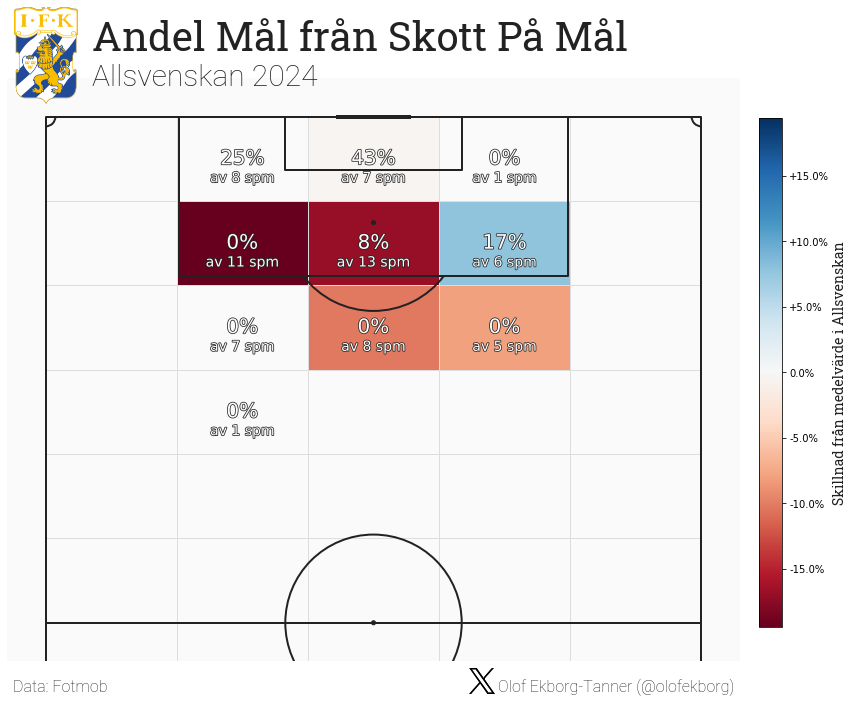

In [21]:
plot_heatmap(kpi='goal%', stds=True, save_fig=True)

/tmp/ipykernel_35444/3534464789.py:6: RuntimeWarning: invalid value encountered in scalar divide
  stds[i][j] = (team_bins[4,i,j] - team_bins[:,i,j].mean()) / team_bins[:,i,j].std()


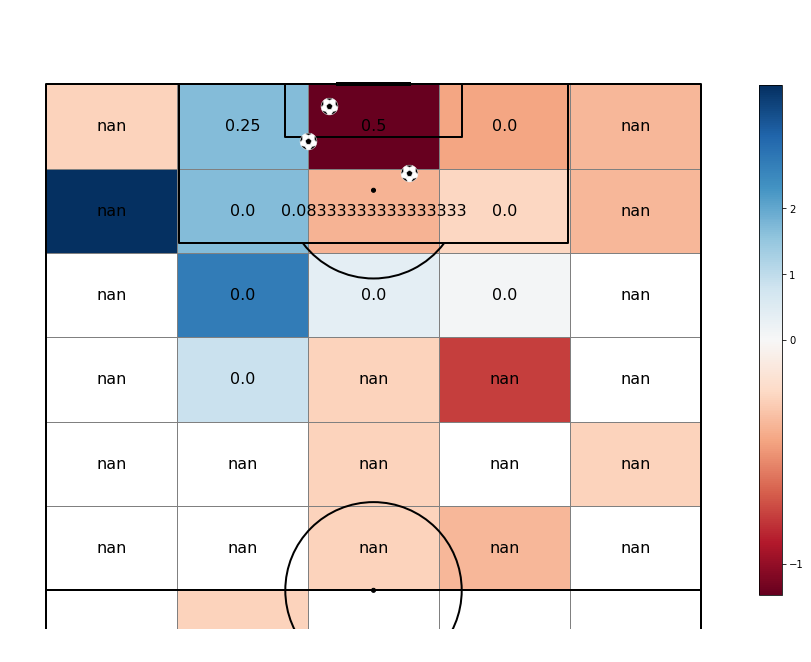

In [225]:
#get the 2D histogram 
bin_statistic = pitch.bin_statistic(df_ifk_shots.x, df_ifk_shots.y, statistic='count', bins=(12, 5), normalize=False)
#normalize by number of games
#bin_statistic["statistic"] = bin_statistic["statistic"] / len(df_ifk_matches)
bin_statistic["statistic"] = get_stds(team_bins)


#plot pitch
pitch = VerticalPitch(pitch_type='custom',pitch_length=105, pitch_width=68,line_color='black', half=True,line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)


#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='RdBu',norm=TwoSlopeNorm(0), edgecolor='grey', ax=ax['pitch'])
#add labels
bin_labels = bin_statistic.copy()
#bin_labels['statistic'] = ranks
bin_labels = bin_statistic_shots
labels = pitch.label_heatmap(bin_labels, color='black', fontsize=16, ax=ax['pitch'], ha='center', va='center', zorder=3)
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar,ticks=range(-3,3))


pitch.scatter(df_ifk_goals.x, df_ifk_goals.y, alpha=1, s=300, marker='football', edgecolor='#f3f3f3', ax=ax['pitch'],zorder=3) 

plt.savefig(f'shotmap_ifk_std.png', bbox_inches='tight', dpi=300, transparent=False)
plt.show()